In [1]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community as community_louvain

In [3]:
aims = pd.read_csv("data/AIMS-GHANA-NET2425.csv", delimiter="\t")
aims.head()

,First_Name,Country,Background,Friend1,Friend2,Friend3
0,Bella,Burundi,Statistics,DicksonJ,Cubaka,Carine
1,Bright,Ghana,Mathematics Education,Richard,DicksonA,Isaac
2,DicksonA,Ghana,Mathematics,Bright,Richard,Isaac
3,Richard,Ghana,Statistics,Bright,DicksonA,Isaac
4,SamuelA,Ghana,Physics,Ernestina,Zanitar,Nondi


# Data cleaning

In [4]:
# Striping the whitespaces
for col in aims.columns:
    aims[col]=aims[col].str.strip()

In [5]:
# Setting the Background to sentence case
aims["Background"]=aims["Background"].str.capitalize()

# Visualizing the graph

In [6]:
G = nx.Graph()

# Adding nodes and their attributes
for _, row in aims.iterrows():
    G.add_node(row["First_Name"], Country = row["Country"], Background = row["Background"])
    
# Adding edges between friends
for _, row in aims.iterrows():
    # Assuming Friend1, Friend2, Friend3 are columns with names of friends
    friends = [row["Friend1"], row["Friend2"], row["Friend3"]]
    
    # Add edges between each pair of friends
    for i in range(len(friends)):
        G.add_edge(row["First_Name"], friends[i])

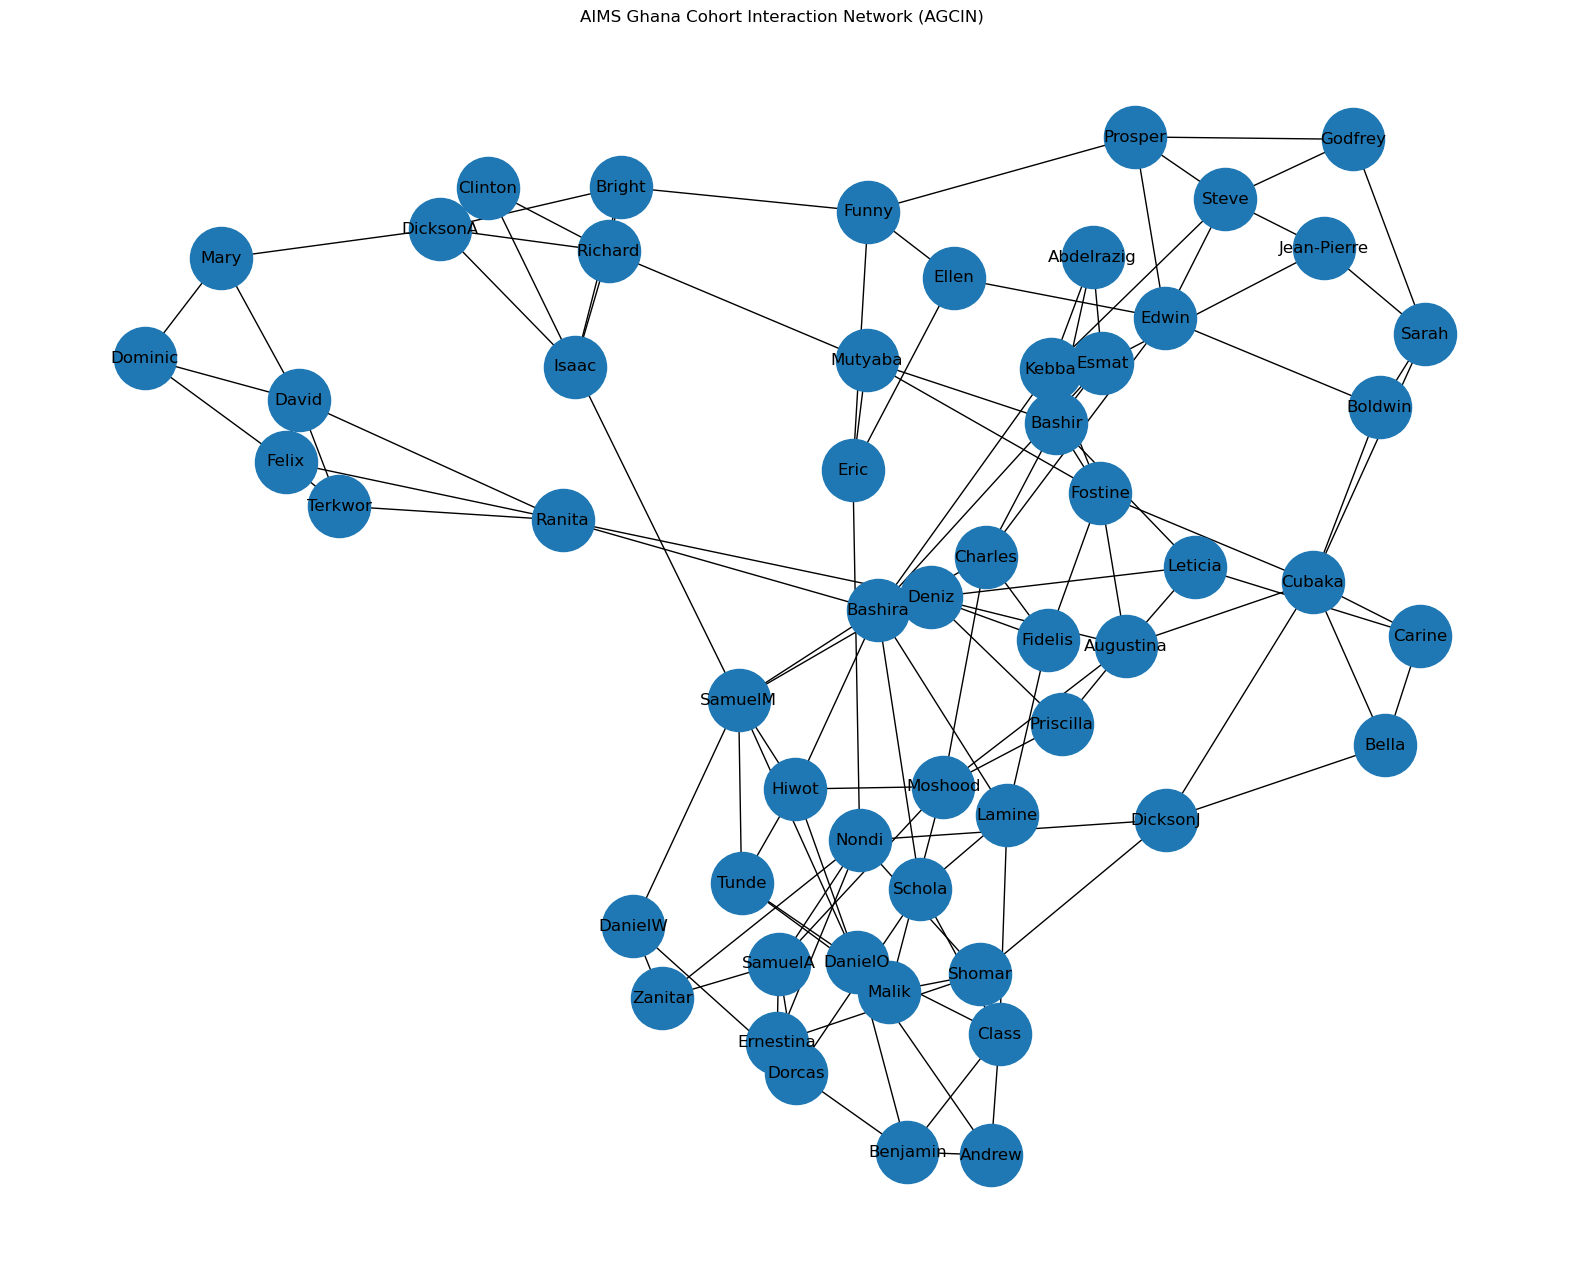

In [46]:
fig, ax = plt.subplots(figsize=(20, 16))

# Draw the graph on the axis
nx.draw(G, with_labels=True, node_size=2000, ax=ax)
plt.title("AIMS Ghana Cohort Interaction Network (AGCIN) ")
plt.show()
# Save the figure
fig.savefig("images/graph_visualization.png", format="png", dpi=300, bbox_inches='tight')

# Visualizing with country

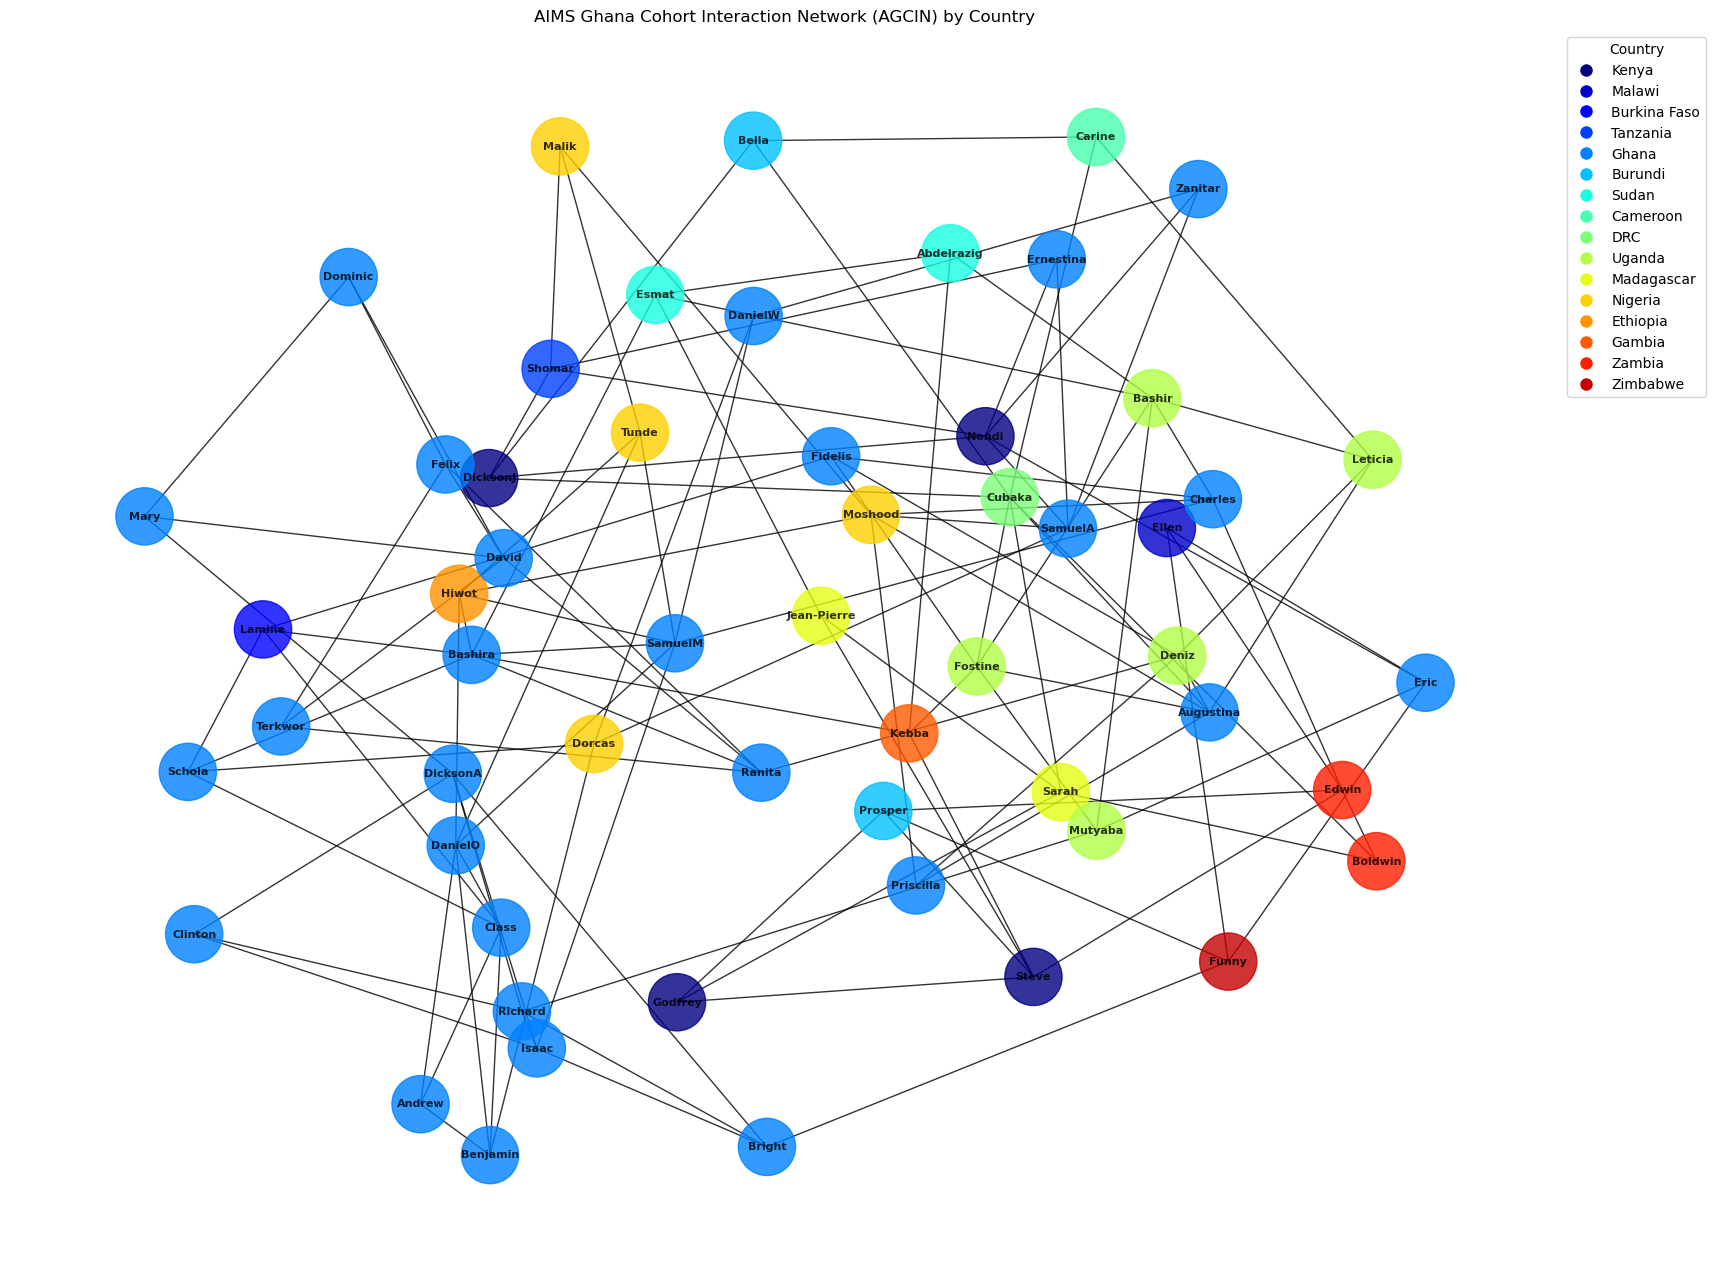

In [45]:
from matplotlib.lines import Line2D

# Extracting the list of unique countries
countries = list(set([data["Country"] for _, data in G.nodes(data=True)]))

# Define a color map for countries
color_map = {country: plt.cm.jet(i / len(countries)) for i, country in enumerate(countries)}
node_colors = [color_map[G.nodes[node]["Country"]] for node in G.nodes]

fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.spring_layout(G, k=0.8, seed=14)
nx.draw(G,pos, with_labels=True, node_color=node_colors, font_weight='bold', node_size=1700, font_size=8, alpha = 0.8, ax=ax)

# Create a legend based on countries
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[country], markersize=10, label=country) for country in countries]
plt.legend(handles=legend_elements, title="Country", loc='upper left', bbox_to_anchor=(1, 1))
plt.title("AIMS Ghana Cohort Interaction Network (AGCIN) by Country")
plt.show()

# Save the figure
fig.savefig("images/graph_visualization_by_country.png", format="png", dpi=300, bbox_inches='tight')

In [16]:
len(G.edges())

120

In [17]:
len(G.nodes())

56

1. Is the network connected? (Graph structure and components)

In [18]:
nx.is_connected(G)

True

In [19]:
nx.is_directed(G)

False

2. Who are the most influential people? (Centrality analysis) What does it tell us about social interactions?

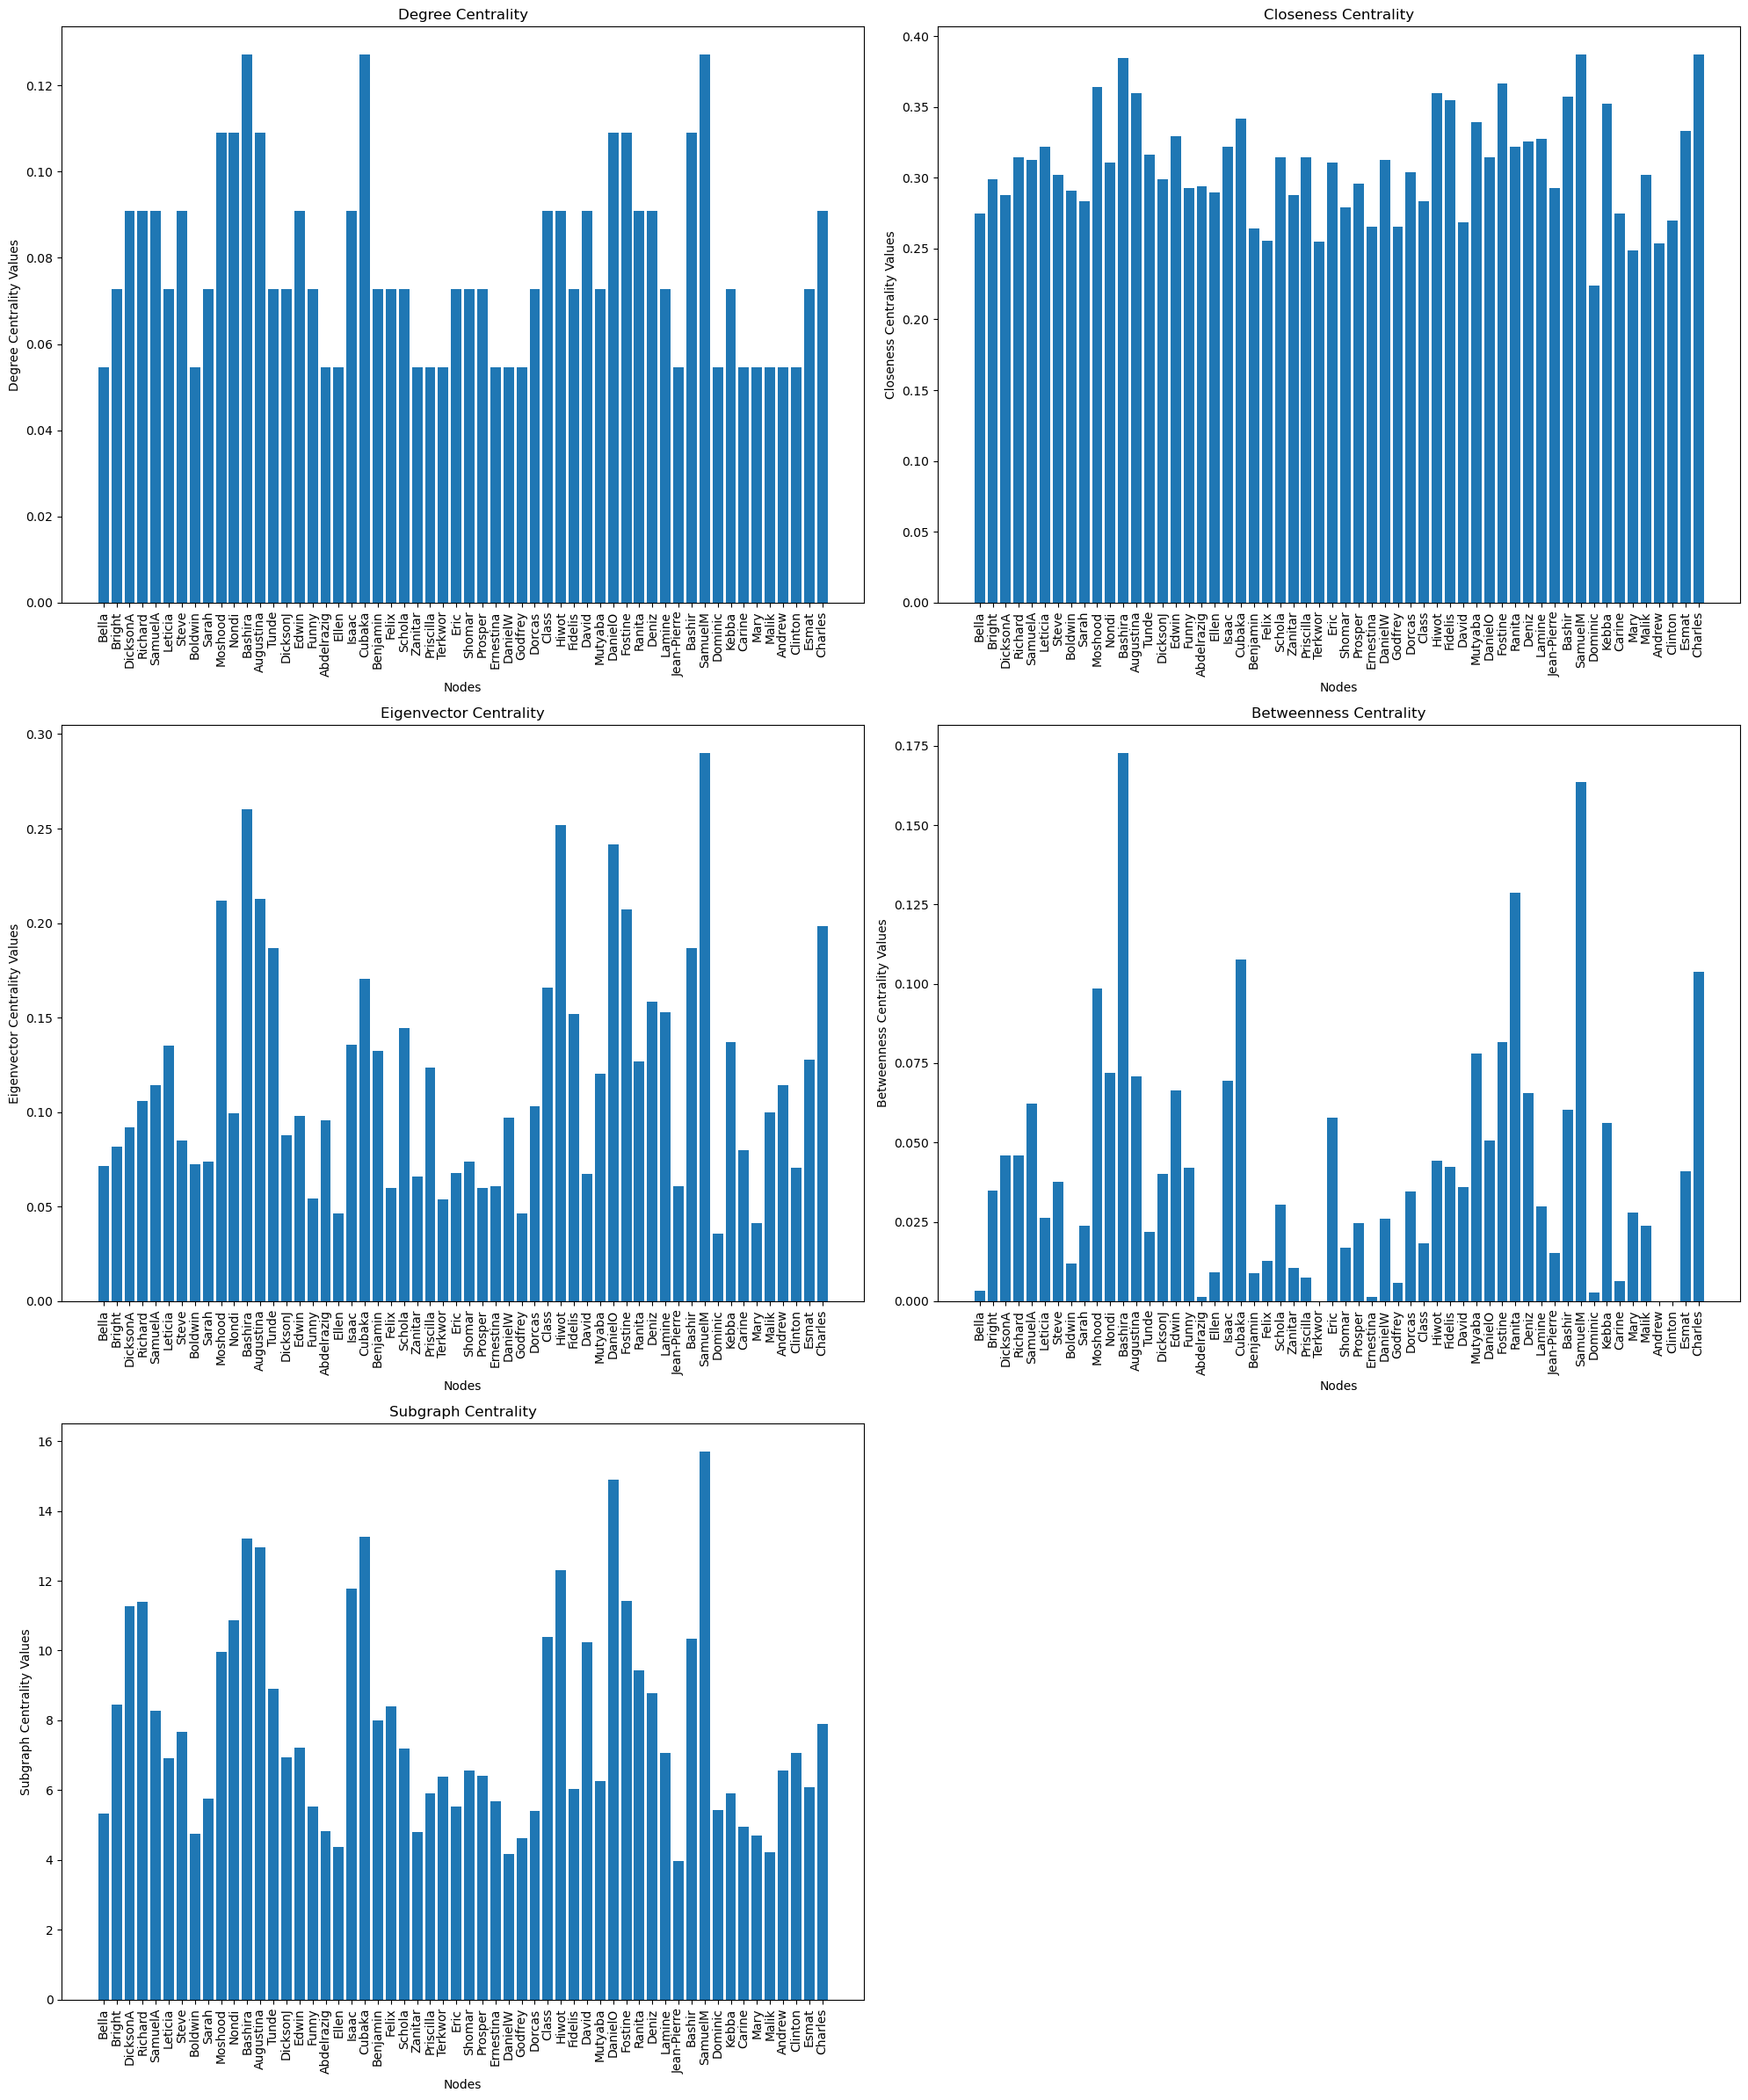

In [21]:
deg_cen = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
eigen = nx.eigenvector_centrality(G)
bet_cen = nx.betweenness_centrality(G)
subgraph = nx.subgraph_centrality(G)

centralities = {
    "Degree Centrality" : deg_cen,  
    "Closeness Centrality" : closeness, 
    "Eigenvector Centrality" : eigen,  
    "Betweenness Centrality" : bet_cen, 
    "Subgraph Centrality" : subgraph,  
}

fig, axs = plt.subplots(3, 2, figsize=(20, 24))
axs = axs.flatten()

for i, (key, values) in enumerate(centralities.items()):
    nodes, values = zip(*values.items())  

    axs[i].bar(nodes, values)
    
    axs[i].set_title(f'{key}') 
    
    axs[i].set_xticks(range(len(nodes)))  
    axs[i].set_xticklabels(nodes, rotation=90)  
    axs[i].set_ylabel(f'{key} Values')  
    axs[i].set_xlabel('Nodes')  

axs[5].axis("off")

plt.tight_layout()
plt.show()
# save figure
fig.savefig("images/graph_on_all_centralities.jpg")

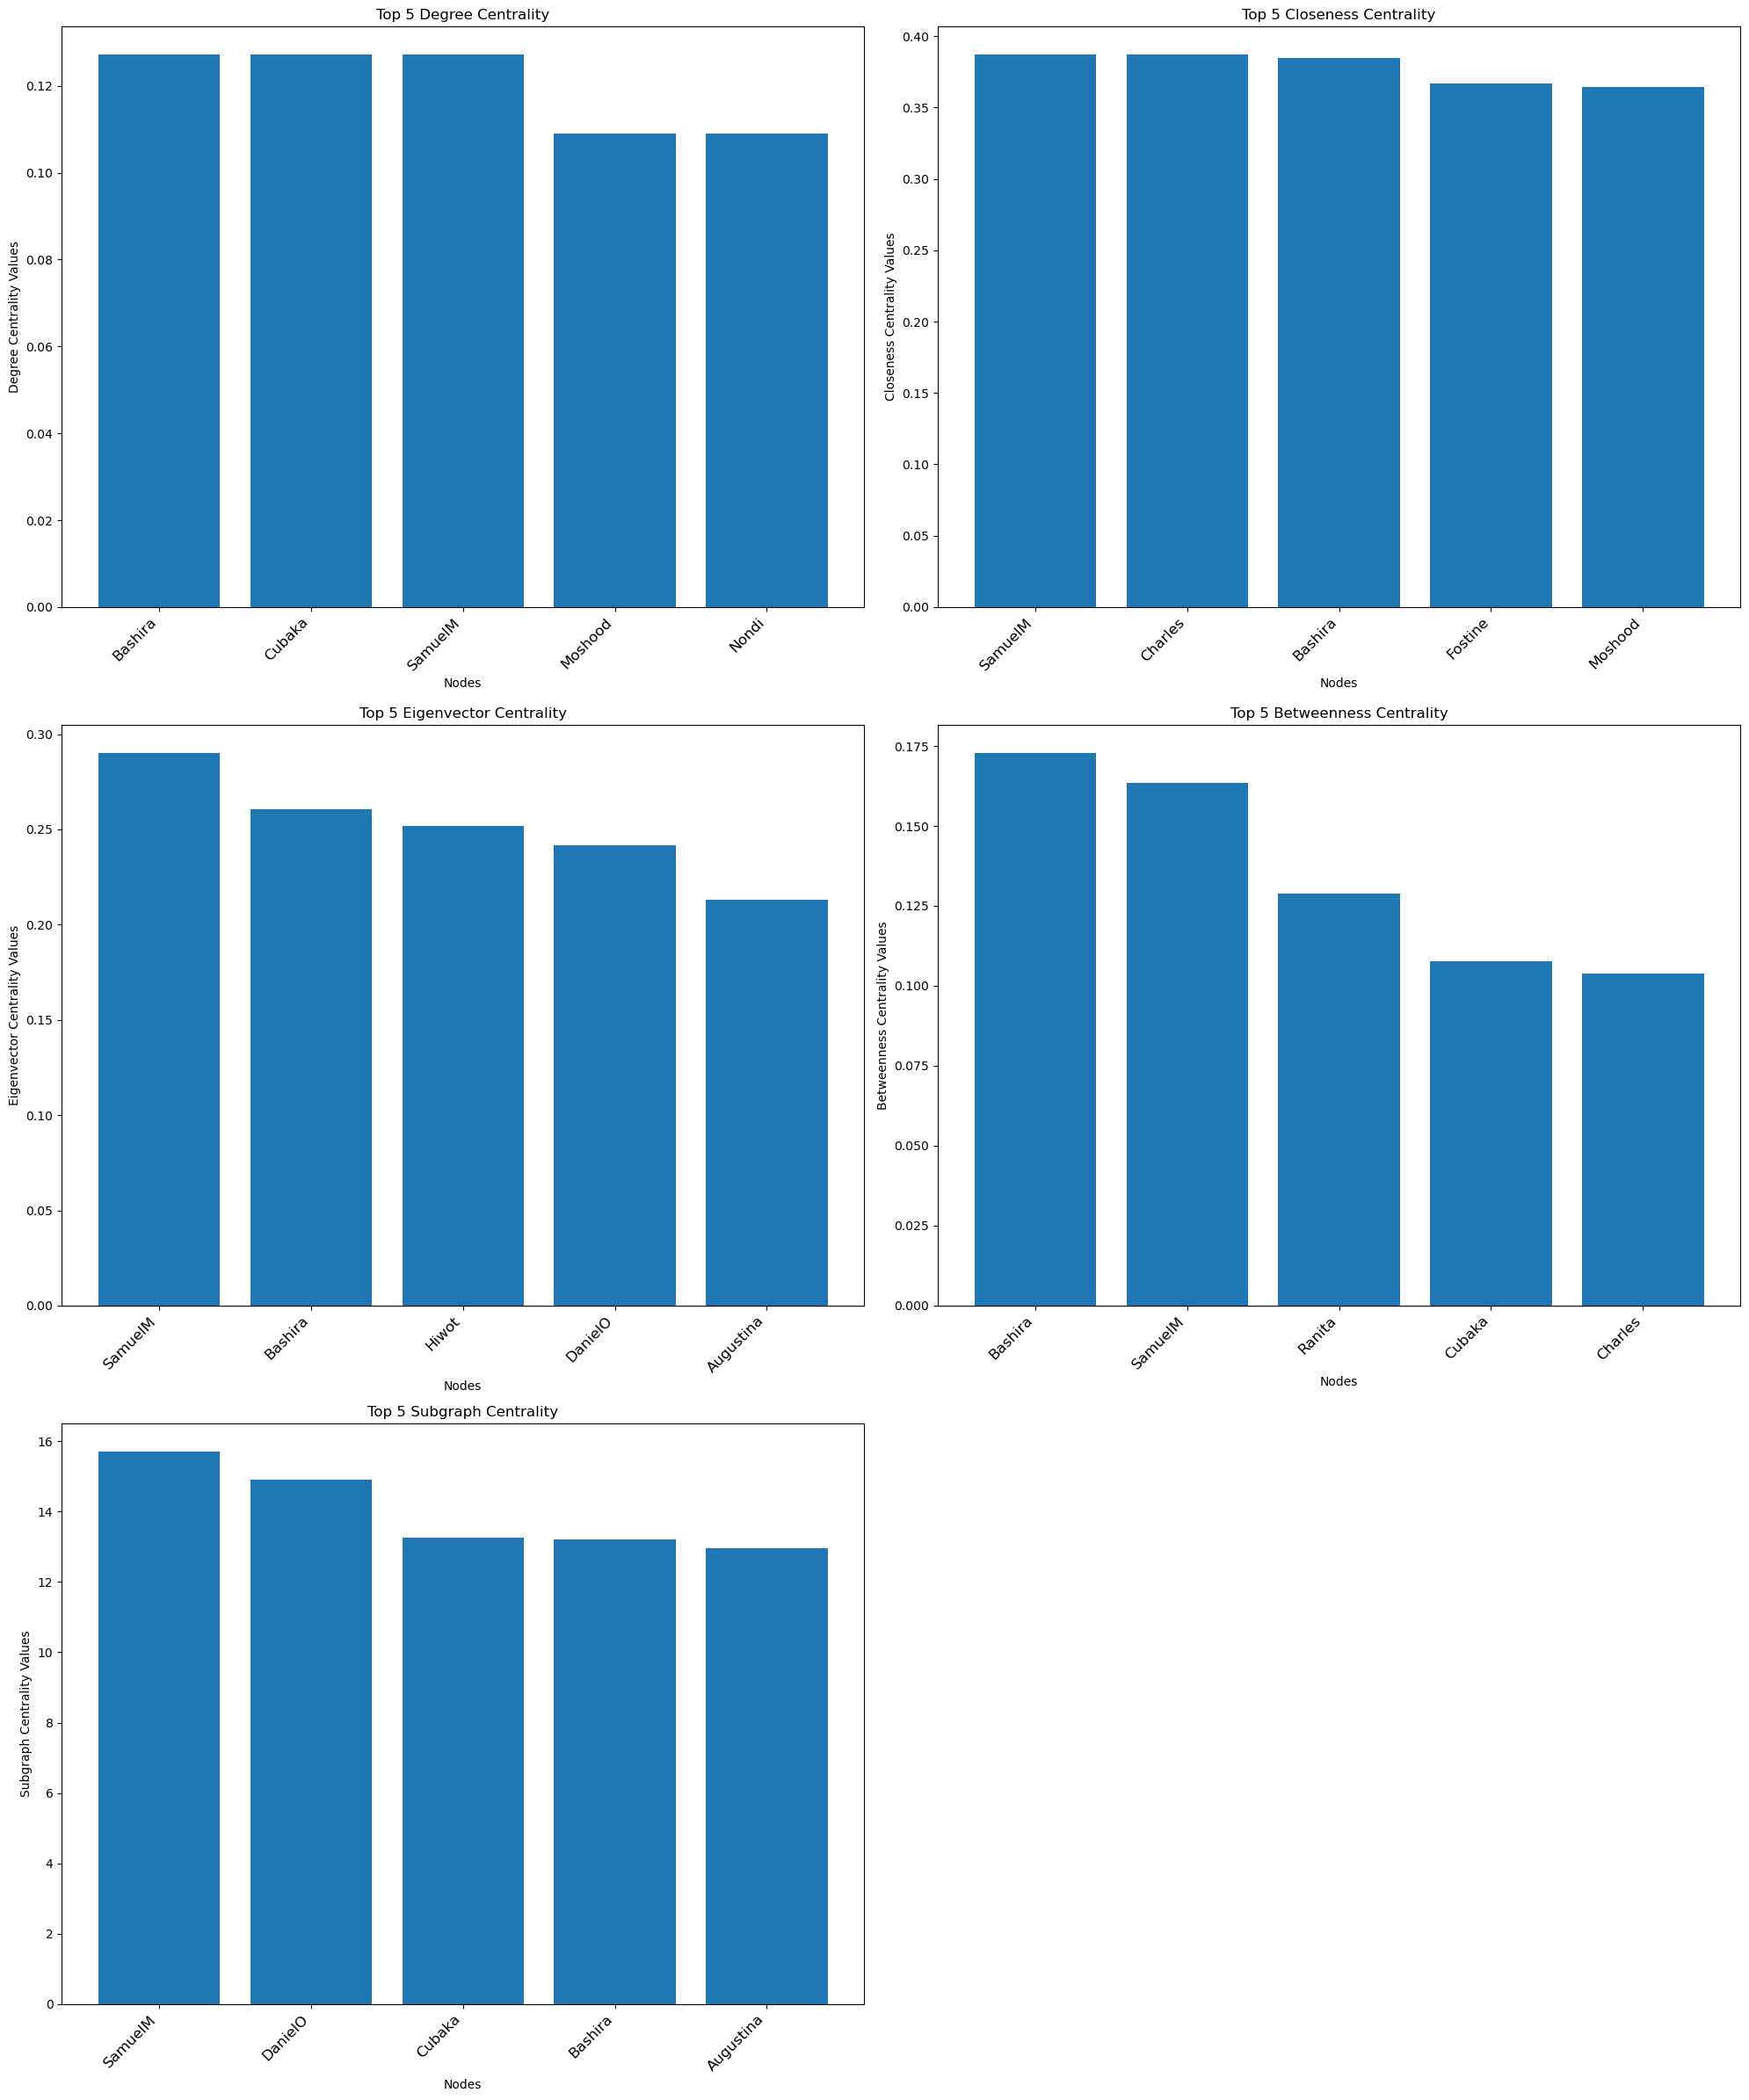

In [43]:
#Plot for top 5 on each centrality

fig, axs = plt.subplots(3, 2, figsize=(20, 24))
axs = axs.flatten()

for i, (key, values) in enumerate(centralities.items()):
    sorted_values = sorted(values.items(), key=lambda item: item[1], reverse=True)[:5]
    nodes, top_values = zip(*sorted_values)

    axs[i].bar(nodes, top_values)
    axs[i].set_title(f'Top 5 {key}')
    
    axs[i].set_xticks(range(len(nodes)))
    axs[i].set_xticklabels(nodes, rotation=45, ha='right', fontsize=12)
    axs[i].set_ylabel(f'{key} Values')
    axs[i].set_xlabel('Nodes')

axs[5].axis('off')
plt.tight_layout()
plt.show()

# save figure
fig.savefig("images/graph_of_top5_across_all_centralities.jpg")

 3. What is the degree distribution? (Network density)

In [23]:
nx.density(G)

0.07792207792207792

 4. Are there communities? (Community detection)

In [24]:
# Apply Louvain's community detection
partition = community_louvain.best_partition(G)

communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

Modularity of a partition of the graph

In [25]:
community_louvain.modularity(partition,G)

0.5885416666666666

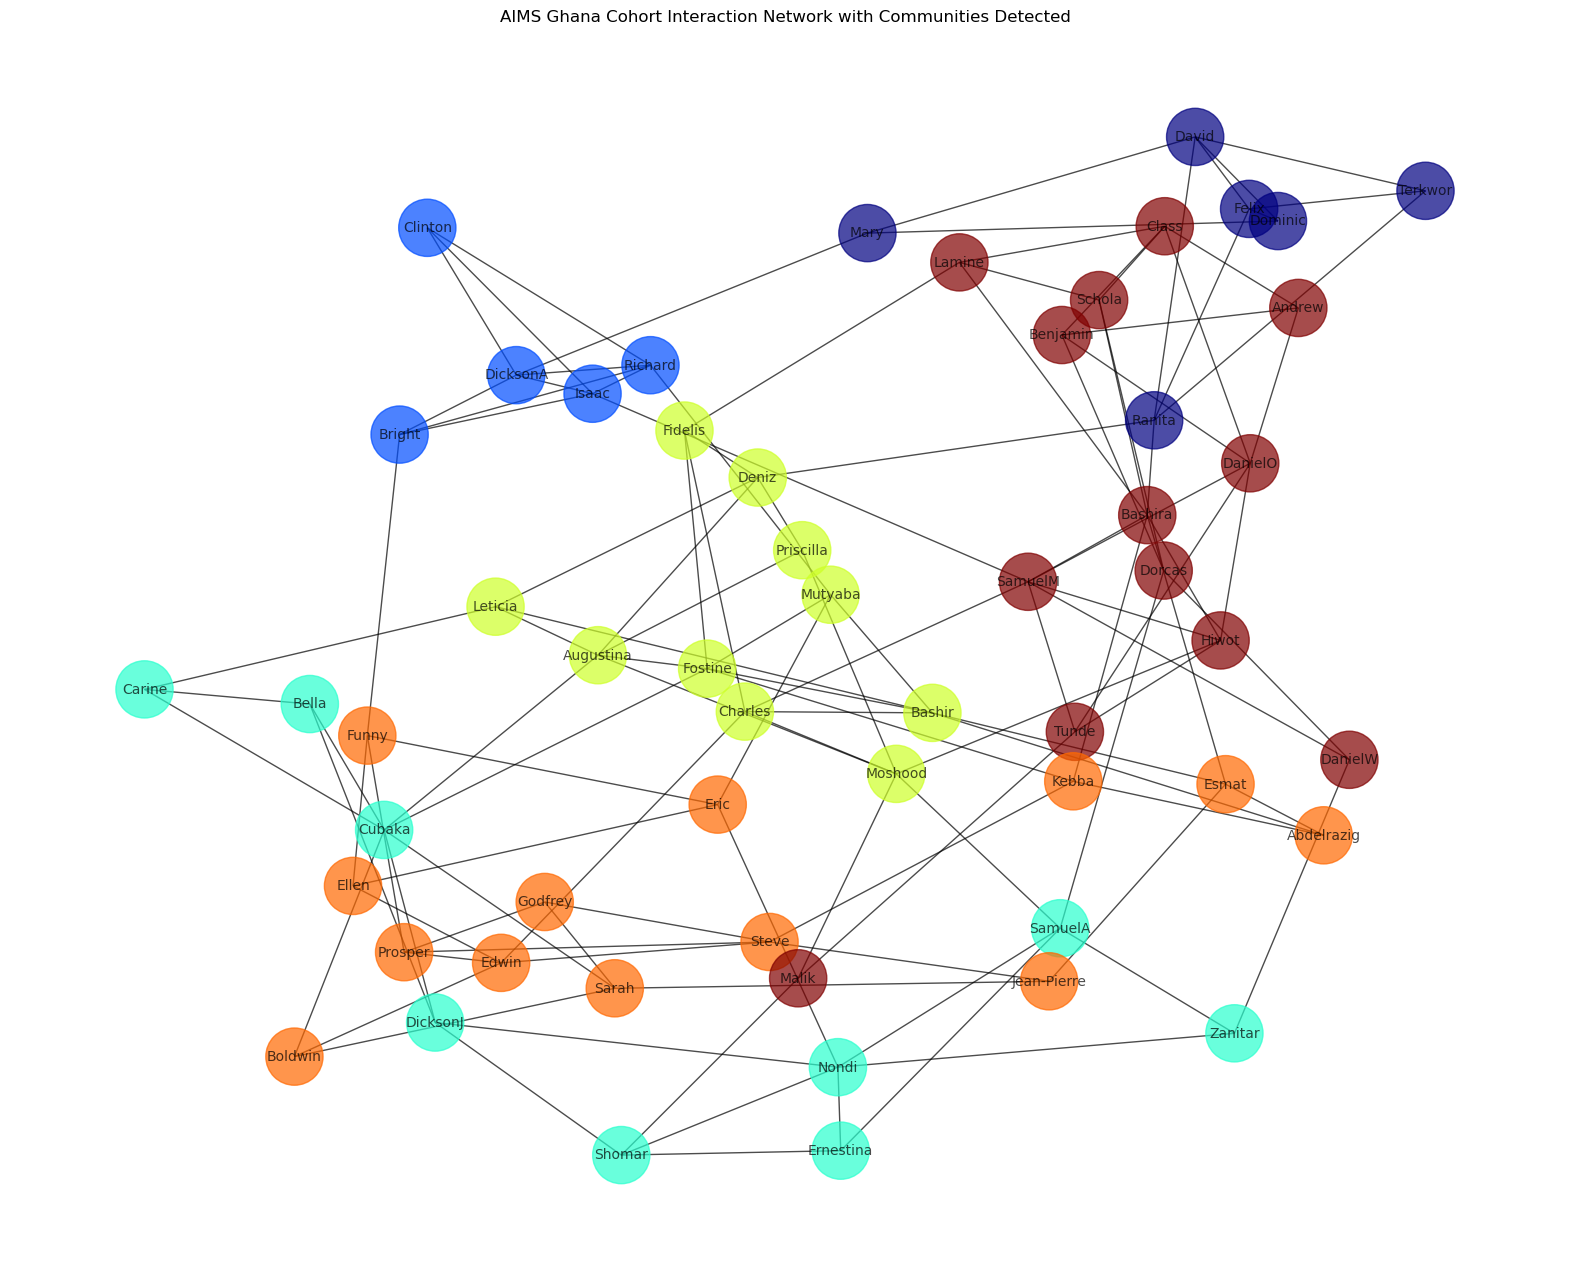

In [44]:
# Draw the graph with node colors representing communities
fig, ax = plt.subplots(figsize=(20, 16))

community_colors = [partition[node] for node in G.nodes]
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw(G, pos, with_labels=True, node_color=community_colors, cmap=plt.cm.jet, 
        node_size=1700, font_size=10, alpha = 0.7, font_color="black", ax = ax)
plt.title("AIMS Ghana Cohort Interaction Network with Communities Detected")
plt.show()

# save figure
fig.savefig("images/graph_visualization_on_interaction_within_communities.png", format="png", dpi=300, bbox_inches='tight')

List of members in each community

In [28]:
# Print out the nodes in each community
print("Nodes in each community:")
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")


Nodes in each community:
Community 2: ['Bella', 'SamuelA', 'Nondi', 'DicksonJ', 'Cubaka', 'Zanitar', 'Shomar', 'Ernestina', 'Carine']
Community 1: ['Bright', 'DicksonA', 'Richard', 'Isaac', 'Clinton']
Community 3: ['Leticia', 'Moshood', 'Augustina', 'Priscilla', 'Fidelis', 'Mutyaba', 'Fostine', 'Deniz', 'Bashir', 'Charles']
Community 4: ['Steve', 'Boldwin', 'Sarah', 'Edwin', 'Funny', 'Abdelrazig', 'Ellen', 'Eric', 'Prosper', 'Godfrey', 'Jean-Pierre', 'Kebba', 'Esmat']
Community 5: ['Bashira', 'Tunde', 'Benjamin', 'Schola', 'DanielW', 'Dorcas', 'Class', 'Hiwot', 'DanielO', 'Lamine', 'SamuelM', 'Malik', 'Andrew']
Community 0: ['Felix', 'Terkwor', 'David', 'Ranita', 'Dominic', 'Mary']


List of members in each community with their country and background so as to detect their similarities

In [30]:
for community_id, members in communities.items():
    print(f"\nCommunity {community_id}:")
    for member in members:
        country = G.nodes[member].get('Country') 
        background = G.nodes[member].get('Background')  
        print(f"  {member}: Country = {country}, Background = {background}")
     


Community 2:
  Bella: Country = Burundi, Background = Statistics
  SamuelA: Country = Ghana, Background = Physics
  Nondi: Country = Kenya, Background = Mathematics
  DicksonJ: Country = Kenya, Background = Mathematics
  Cubaka: Country = DRC, Background = Mathematics
  Zanitar: Country = Ghana, Background = Mathematics
  Shomar: Country = Tanzania, Background = Mathematics
  Ernestina: Country = Ghana, Background = Mathematics
  Carine: Country = Cameroon, Background = Physics

Community 1:
  Bright: Country = Ghana, Background = Mathematics education
  DicksonA: Country = Ghana, Background = Mathematics
  Richard: Country = Ghana, Background = Statistics
  Isaac: Country = Ghana, Background = Mathematics
  Clinton: Country = Ghana, Background = Mathematics

Community 3:
  Leticia: Country = Uganda, Background = Mathematics
  Moshood: Country = Nigeria, Background = Mathematics
  Augustina: Country = Ghana, Background = Mathematics
  Priscilla: Country = Ghana, Background = Mathemati

5. How far apart are people? (Shortest path and distances)

In [31]:
all_shortest_paths = nx.all_pairs_shortest_path_length(G)

# Example: Print shortest paths between all pairs
for node, paths in all_shortest_paths:
    print(f"Shortest path lengths from {node}: {paths} \n")

Shortest path lengths from Bella: {'Bella': 0, 'DicksonJ': 1, 'Cubaka': 1, 'Carine': 1, 'Nondi': 2, 'Shomar': 2, 'Boldwin': 2, 'Sarah': 2, 'Augustina': 2, 'Fostine': 2, 'Leticia': 2, 'SamuelA': 3, 'Eric': 3, 'Zanitar': 3, 'Ernestina': 3, 'Malik': 3, 'Edwin': 3, 'Jean-Pierre': 3, 'Godfrey': 3, 'Moshood': 3, 'Priscilla': 3, 'Deniz': 3, 'Fidelis': 3, 'Mutyaba': 3, 'Bashir': 3, 'Kebba': 3, 'Dorcas': 4, 'Ellen': 4, 'Funny': 4, 'DanielW': 4, 'Tunde': 4, 'Steve': 4, 'Charles': 4, 'Prosper': 4, 'Esmat': 4, 'Hiwot': 4, 'Ranita': 4, 'Lamine': 4, 'Richard': 4, 'Abdelrazig': 4, 'Bashira': 4, 'Benjamin': 5, 'Schola': 5, 'Bright': 5, 'SamuelM': 5, 'DanielO': 5, 'Felix': 5, 'Terkwor': 5, 'David': 5, 'Class': 5, 'DicksonA': 5, 'Isaac': 5, 'Clinton': 5, 'Andrew': 6, 'Dominic': 6, 'Mary': 6} 

Shortest path lengths from Bright: {'Bright': 0, 'Richard': 1, 'DicksonA': 1, 'Isaac': 1, 'Funny': 1, 'Mutyaba': 2, 'Clinton': 2, 'Mary': 2, 'SamuelM': 2, 'Ellen': 2, 'Prosper': 2, 'Eric': 2, 'Fostine': 3, 'Bashir

In [33]:
distances = nx.eccentricity(G)
distances

{'Bella': 6,
 'Bright': 5,
 'DicksonA': 5,
 'Richard': 4,
 'SamuelA': 6,
 'Leticia': 5,
 'Steve': 5,
 'Boldwin': 6,
 'Sarah': 6,
 'Moshood': 5,
 'Nondi': 6,
 'Bashira': 4,
 'Augustina': 4,
 'Tunde': 5,
 'DicksonJ': 6,
 'Edwin': 6,
 'Funny': 5,
 'Abdelrazig': 5,
 'Ellen': 6,
 'Isaac': 5,
 'Cubaka': 5,
 'Benjamin': 6,
 'Felix': 6,
 'Schola': 5,
 'Zanitar': 6,
 'Priscilla': 5,
 'Terkwor': 6,
 'Eric': 6,
 'Shomar': 7,
 'Prosper': 5,
 'Ernestina': 7,
 'DanielW': 5,
 'Godfrey': 6,
 'Dorcas': 5,
 'Class': 5,
 'Hiwot': 4,
 'Fidelis': 4,
 'David': 6,
 'Mutyaba': 5,
 'DanielO': 5,
 'Fostine': 5,
 'Ranita': 5,
 'Deniz': 5,
 'Lamine': 5,
 'Jean-Pierre': 5,
 'Bashir': 5,
 'SamuelM': 5,
 'Dominic': 7,
 'Kebba': 5,
 'Carine': 6,
 'Mary': 6,
 'Malik': 6,
 'Andrew': 6,
 'Clinton': 5,
 'Esmat': 5,
 'Charles': 5}

In [34]:
nx.average_shortest_path_length(G)

3.2915584415584416

In [35]:
sum(list(distances.values()))/len(list(distances.values()))

5.357142857142857

In [36]:
nx.radius(G)

4

In [37]:
nx.diameter(G)

7

In [38]:
nx.center(G)

['Richard', 'Bashira', 'Augustina', 'Hiwot', 'Fidelis']

6. How clustered is the network? (Clustering coefficient)

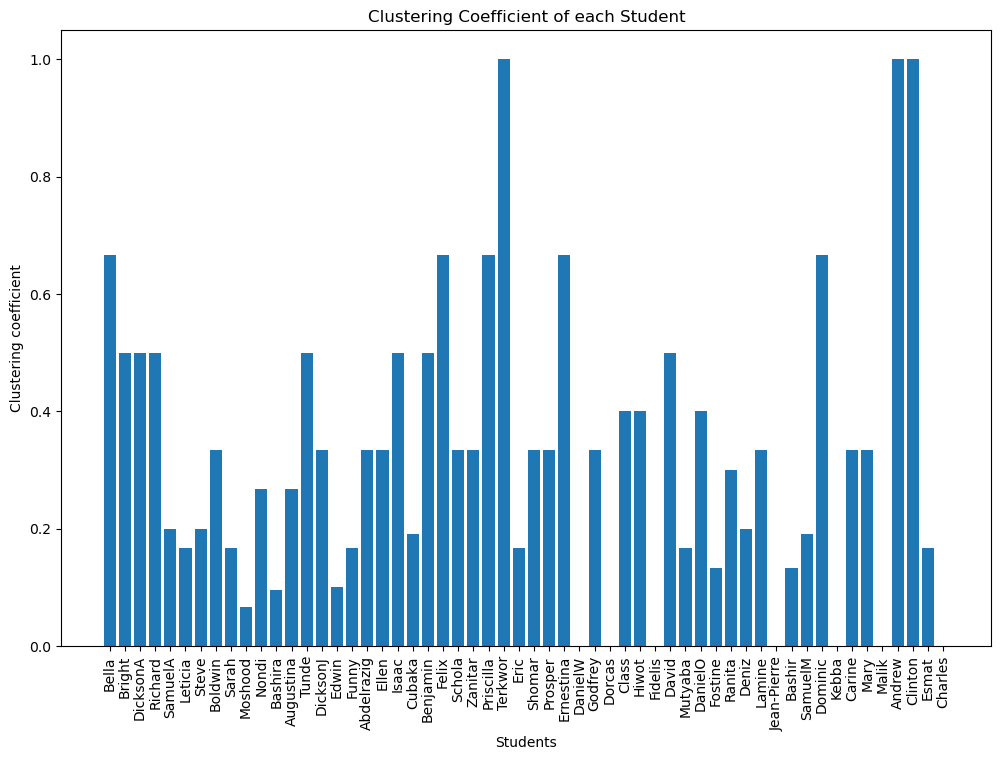

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(cluster.keys(), cluster.values())

ax.set_xticks(list(cluster.keys()))
ax.set_xticklabels(list(cluster.keys()), rotation=90)
ax.set_ylabel("Clustering coefficient")
ax.set_xlabel("Students")
ax.set_title("Clustering Coefficient of each Student")
plt.show()

# Save the figure
fig.savefig("images/graph_of_Clustering_Coefficient_of_Each_Student.jpg", dpi=300, bbox_inches='tight')

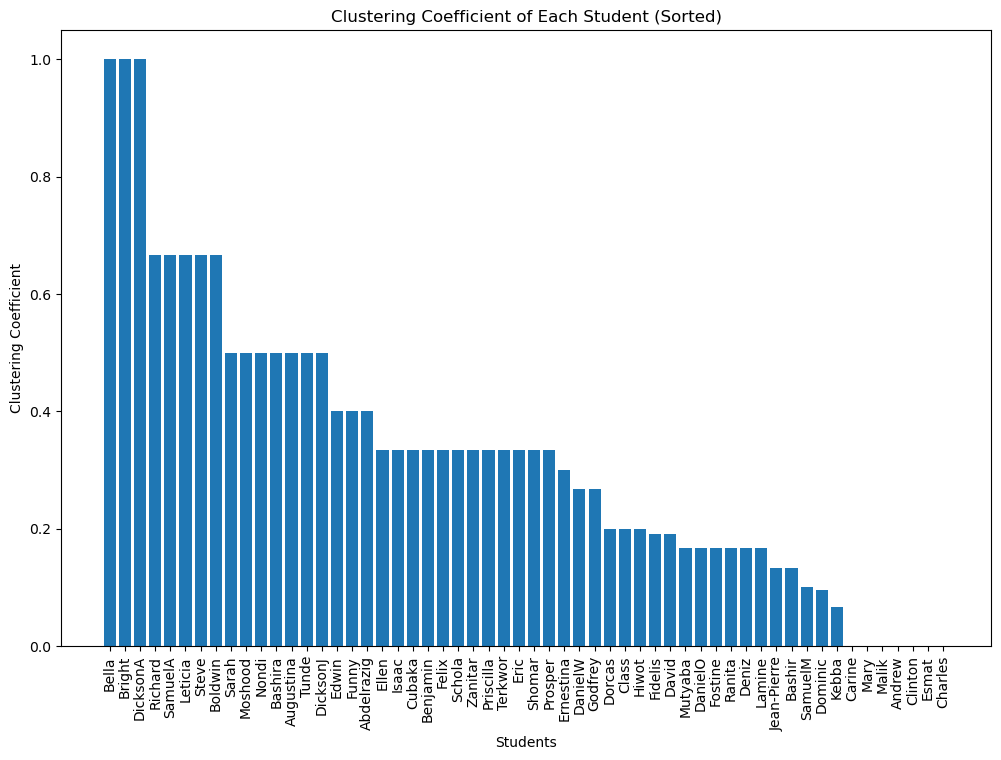

In [49]:
cluster = nx.clustering(G)

sorted_cluster = dict(sorted(cluster.items(), key=lambda item: item[1], reverse=True))
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(sorted_cluster.keys(), sorted_cluster.values())
ax.set_xticks(list(sorted_cluster.keys()))
ax.set_xticklabels(list(cluster.keys()), rotation=90)
ax.set_ylabel("Clustering Coefficient")
ax.set_xlabel("Students")
ax.set_title("Clustering Coefficient of Each Student (Sorted)")  
plt.show()

# Save the figure
fig.savefig("images/graph_of_Clustering_Coefficient_of_Each_Student_sorted.jpg", dpi=300, bbox_inches='tight')

In [50]:
nx.average_clustering(G)

0.32814625850340134

In [51]:
nx.transitivity(G)

0.2777777777777778

 7. Which connections are bridges? (Weak ties)

In [53]:
bridges = list(nx.bridges(G))

print("Bridges (Weak Ties):")
for bridge in bridges:
    print(bridge)

Bridges (Weak Ties):


8. Who controls information flow? (Betweenness and influence)

In [54]:
# Identify the node with the highest betweenness centrality (most influential)
most_influential_node = max(bet_cen, key=bet_cen.get)
print(f"\nNode with the highest betweenness centrality: {most_influential_node} ({bet_cen[most_influential_node]})")


Node with the highest betweenness centrality: Bashira (0.17286525670364056)


9. What happens if key nodes are removed? (Network robustness)

In [55]:
betweenness = nx.betweenness_centrality(G)

most_central_node = max(betweenness, key=betweenness.get)
print(f"Most central node: {most_central_node} (Betweenness Centrality: {betweenness[most_central_node]})")

G_removed = G.copy()

G_removed.remove_node(most_central_node)

connected_components = list(nx.connected_components(G_removed))
num_components = len(connected_components)
print(f"Number of connected components after removing node {most_central_node}: {num_components}")

Most central node: Bashira (Betweenness Centrality: 0.17286525670364056)
Number of connected components after removing node Bashira: 1


What does the degree distribution tell us about social interactions?

In [56]:
degree_dist = nx.average_degree_connectivity(G)
degree_dist

{3: 4.705882352941177,
 4: 4.611111111111111,
 5: 4.483333333333333,
 6: 4.611111111111111,
 7: 4.619047619047619}

In [57]:
nx.degree_histogram(G)

[0, 0, 0, 17, 18, 12, 6, 3]

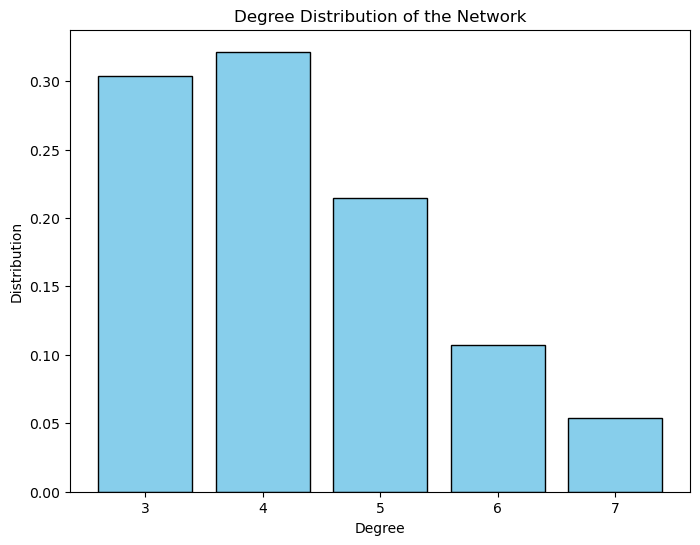

In [59]:
from collections import Counter
# Collecting all the degrees
degrees = [degree for node, degree in G.degree()]
# Setting up the counters
degree_count1= Counter(degrees)
# Prepare the degree distribution data
degree_values = list(degree_count1.keys())
frequency_values = np.array(list(degree_count1.values()))/56

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(degree_values, frequency_values, width=0.8, color='skyblue', edgecolor='black')
ax.set_xlabel('Degree')
ax.set_ylabel('Distribution')
ax.set_title('Degree Distribution of the Network')
plt.show()

# Save the figure
fig.savefig("images/degree_ddistribution_of_the_network.jpg", dpi=300, bbox_inches='tight')

In [60]:
frequency_values.T @ np.array(degree_values)

4.285714285714285

In [61]:
nx.degree_centrality(G)

{'Bella': 0.05454545454545454,
 'Bright': 0.07272727272727272,
 'DicksonA': 0.09090909090909091,
 'Richard': 0.09090909090909091,
 'SamuelA': 0.09090909090909091,
 'Leticia': 0.07272727272727272,
 'Steve': 0.09090909090909091,
 'Boldwin': 0.05454545454545454,
 'Sarah': 0.07272727272727272,
 'Moshood': 0.10909090909090909,
 'Nondi': 0.10909090909090909,
 'Bashira': 0.12727272727272726,
 'Augustina': 0.10909090909090909,
 'Tunde': 0.07272727272727272,
 'DicksonJ': 0.07272727272727272,
 'Edwin': 0.09090909090909091,
 'Funny': 0.07272727272727272,
 'Abdelrazig': 0.05454545454545454,
 'Ellen': 0.05454545454545454,
 'Isaac': 0.09090909090909091,
 'Cubaka': 0.12727272727272726,
 'Benjamin': 0.07272727272727272,
 'Felix': 0.07272727272727272,
 'Schola': 0.07272727272727272,
 'Zanitar': 0.05454545454545454,
 'Priscilla': 0.05454545454545454,
 'Terkwor': 0.05454545454545454,
 'Eric': 0.07272727272727272,
 'Shomar': 0.07272727272727272,
 'Prosper': 0.07272727272727272,
 'Ernestina': 0.05454545454

 12. Who are the most 5 influential students based on the degree centrality? can you say about it?

In [62]:
# Step 1: Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G)

# Step 2: Sort the nodes by degree centrality in descending order
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Step 3: Get the top 5 most influential students based on degree centrality
top_5_influential = sorted_centrality[:5]

# Step 4: Print the most 5 influential students with their degree centrality
print("Top 5 Influential Students based on Degree Centrality:")
for student, centrality in top_5_influential:
    print(f"{student}: Degree Centrality = {centrality:.4f}")

Top 5 Influential Students based on Degree Centrality:
Bashira: Degree Centrality = 0.1273
Cubaka: Degree Centrality = 0.1273
SamuelM: Degree Centrality = 0.1273
Moshood: Degree Centrality = 0.1091
Nondi: Degree Centrality = 0.1091


13. What role do isolated students play, and should they be integrated more?

In [63]:
def common_neighbors(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

def jaccard_index(u, v):
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    intersection = len(neighbors_u.intersection(neighbors_v))
    union = len(neighbors_u.union(neighbors_v))
    if union == 0:
        return 0
    else:
        return intersection / union


def predict_friendships(G, top_n=5):
    potential_friendships = []
    
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):  
                common_neighbors_count = common_neighbors(u, v)
                jaccard_sim = jaccard_index(u, v)
                
                potential_friendships.append(((u, v), common_neighbors_count, jaccard_sim))
    
    potential_friendships_sorted = sorted(potential_friendships, key=lambda x: x[2], reverse=True)
    return potential_friendships_sorted[:top_n]

top_10_predictions = predict_friendships(G, top_n=10)

print("Top 10 Predicted Friendships Based on Common Connections:")
for (u, v), common_neighbors_count, jaccard_sim in top_10_predictions:
    print(f"Prediction: {u} and {v} (Common Neighbors: {common_neighbors_count}, Jaccard Index: {jaccard_sim:.4f})")


Top 10 Predicted Friendships Based on Common Connections:
Prediction: Bright and Clinton (Common Neighbors: 3, Jaccard Index: 0.7500)
Prediction: Clinton and Bright (Common Neighbors: 3, Jaccard Index: 0.7500)
Prediction: Zanitar and Ernestina (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Terkwor and Dominic (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Ernestina and Zanitar (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Godfrey and Jean-Pierre (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Jean-Pierre and Godfrey (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Dominic and Terkwor (Common Neighbors: 2, Jaccard Index: 0.5000)
Prediction: Leticia and Priscilla (Common Neighbors: 2, Jaccard Index: 0.4000)
Prediction: DicksonJ and Ernestina (Common Neighbors: 2, Jaccard Index: 0.4000)
